## Key findings and achievements

> * Compared three classification models to predict loan approval (Logistic Regression, Decision Tree, Random Forest).
> * Selected the best performing model and carried out predictions on test set.
> * Interpreted the prediction by looking at feature importance.

___

## Introduction

Obtaining loans for various purposes has become an integral part of our lives, whether it's financing a dream home, pursuing higher education, or launching a business venture. However, the loan approval process can be complex, time-consuming, and sometimes uncertain for both borrowers and lenders. This short notebook aims to explore the world of predictive modeling in the domain of finance, specifically focusing on the task of predicting loan approval.

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

## Data

In [58]:
df = pd.read_csv('../../data/loan_approval_dataset.csv')
df.columns = [col.strip() for col in df.columns]
df = df.drop(columns=['loan_id'])

# Label-encoding categorical variables
df['loan_status'] = df['loan_status'].map(
    {
        ' Approved': 1,
        ' Rejected': 0
    }
)

df['education'] = df['education'].map(
    {
        ' Graduate': 1,
        ' Not Graduate': 0
    }
)

df['self_employed'] = df['self_employed'].map(
    {
        ' Yes': 1,
        ' No': 0
    }
)

# Given that the dataset's financial values are expressed in INR (Indian rupee), 
# let's convert them to EUR (Euro) for easier interpretation of the amounts.
df[
    ['income_annum', 'loan_amount', 'residential_assets_value', 
     'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']] = df[
    ['income_annum', 'loan_amount', 'residential_assets_value', 
     'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']] * 0.01115
     
     
print(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   no_of_dependents          4269 non-null   int64  
 1   education                 4269 non-null   int64  
 2   self_employed             4269 non-null   int64  
 3   income_annum              4269 non-null   float64
 4   loan_amount               4269 non-null   float64
 5   loan_term                 4269 non-null   int64  
 6   cibil_score               4269 non-null   int64  
 7   residential_assets_value  4269 non-null   float64
 8   commercial_assets_value   4269 non-null   float64
 9   luxury_assets_value       4269 non-null   float64
 10  bank_asset_value          4269 non-null   float64
 11  loan_status               4269 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 400.3 KB
None


,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,"107,040.00","333,385.00",12,778,"26,760.00","196,240.00","253,105.00","89,200.00",1
1,0,0,1,"45,715.00","136,030.00",8,417,"30,105.00","24,530.00","98,120.00","36,795.00",0
2,3,1,0,"101,465.00","331,155.00",20,506,"79,165.00","50,175.00","371,295.00","142,720.00",0
3,3,1,0,"91,430.00","342,305.00",8,467,"202,930.00","36,795.00","259,795.00","88,085.00",0
4,5,0,1,"109,270.00","269,830.00",20,382,"138,260.00","91,430.00","327,810.00","55,750.00",0
...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,1,1,"11,150.00","25,645.00",12,317,"31,220.00","5,575.00","36,795.00","8,920.00",0
4265,0,0,1,"36,795.00","125,995.00",20,559,"46,830.00","32,335.00","122,650.00","21,185.00",1
4266,2,0,0,"72,475.00","266,485.00",18,457,"13,380.00","138,260.00","201,815.00","81,395.00",0
4267,1,0,0,"45,715.00","142,720.00",8,780,"91,430.00","7,805.00","157,215.00","64,670.00",1


The dataset that will be used contains financials and demographic information from an Indian sample, where various attributes of individuals are recorded to analyze and predict loan approval or assess credit risk.

* `no_of_dependents`: An integer column denoting the number of dependents the individual has.
* `education`: An integer column, likely representing different levels of education or educational qualifications.
* `self_employed`: An integer column, potentially indicating if the individual is self-employed or not.
* `income_annum`: A floating-point column showing the annual income of the individual.
* `loan_amount`: A floating-point column indicating the amount of the loan.
* `loan_term`: An integer column representing the duration or term of the loan in some unit (e.g., months).
* `cibil_score`: An integer column, possibly representing the credit score of the individual.
* `residential_assets_value`: A floating-point column denoting the value of residential assets owned by the individual.
* `commercial_assets_value`: A floating-point column indicating the value of commercial assets owned by the individual.
* `luxury_assets_value`: A floating-point column representing the value of luxury assets owned by the individual.
* `bank_asset_value`: A floating-point column indicating the value of assets held in banks by the individual.
* `loan_status`: An integer column, likely representing the status of the loan (e.g., approved, rejected, etc.).

All columns have the same number of non-null entries, suggesting that there are no missing values.

Before presenting the final dataset, we have carried out the following transformations:
1. Label-encoded `loan_status`, `education`, and `self_employed` variables.
2. Converted amount from INR (Indian rupee) to EUR (Euro) at an exchange rate of 0.01115.

## Exploratory analysis

The first step is to explore the available variables, looking for potential relationships with the target variable `loan_status`.

In [59]:
df.describe()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,"4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00","4,269.00"
mean,2.50,0.50,0.50,"56,409.23","168,737.97",10.90,599.94,"83,319.67","55,450.68","168,658.31","55,490.12",0.62
std,1.70,0.50,0.50,"31,296.26","100,833.50",5.71,172.43,"72,515.55","48,936.97","101,506.85","36,239.57",0.48
min,0.00,0.00,0.00,"2,230.00","3,345.00",2.00,300.00,"-1,115.00",0.00,"3,345.00",0.00,0.00
25%,1.00,0.00,0.00,"30,105.00","85,855.00",6.00,453.00,"24,530.00","14,495.00","83,625.00","25,645.00",0.00
50%,3.00,1.00,1.00,"56,865.00","161,675.00",10.00,600.00,"62,440.00","41,255.00","162,790.00","51,290.00",1.00
75%,4.00,1.00,1.00,"83,625.00","239,725.00",16.00,748.00,"125,995.00","84,740.00","241,955.00","79,165.00",1.00
max,5.00,1.00,1.00,"110,385.00","440,425.00",20.00,900.00,"324,465.00","216,310.00","437,080.00","163,905.00",1.00


We discover a very strong correlation between `loan_status` and `cibil_score`, suggesting that loan approval is highly dependant on the financial score of the applicant. 

In [60]:
df.corr()[['loan_status']].sort_values('loan_status', ascending=False)[1:]

,loan_status
cibil_score,0.77
loan_amount,0.02
commercial_assets_value,0.01
education,0.00
self_employed,0.00
bank_asset_value,-0.01
residential_assets_value,-0.01
income_annum,-0.02
luxury_assets_value,-0.02
no_of_dependents,-0.02


<Axes: >

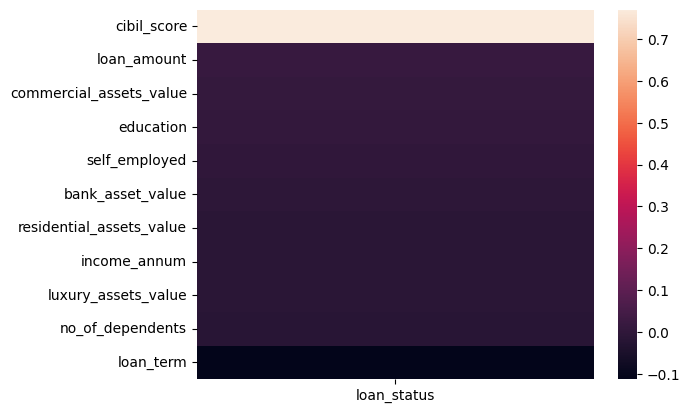

In [61]:
sns.heatmap(df.corr()[['loan_status']].sort_values('loan_status', ascending=False)[1:])

<Axes: xlabel='cibil_score', ylabel='loan_status'>

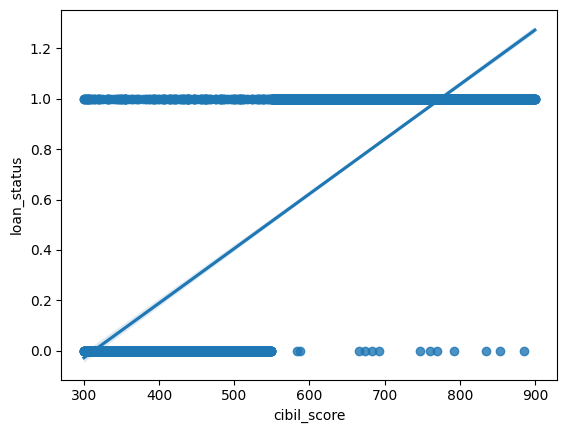

In [62]:
sns.regplot(df, y='loan_status', x='cibil_score')

The positive relationship between the `cibil_score` and `loan_status` variables is confirmed by the regression analysis. As the `cibil_score` increases, the `loan_status` also increases, suggesting that a higher credit score may be associated with a higher likelihood of a positive loan status (e.g., loan approval).

## Predicting loan approval

Since we aim to predict loan approval, our target variable will be `loan_status`. We will initially compare three of the most commonly used classification algorithms (Logistic Regression, Decision Tree, and Random Forest) and select the one demonstrating the best performance. We will measure the performance using the F1 score as the indicator.

The F1 score is a metric that combines both precision and recall. Precision measures the accuracy of positive predictions, while recall measures the model's ability to capture all positive instances. The F1 score considers both false positives and false negatives, providing a balanced assessment of a model's performance, especially in situations where there is an imbalance between the classes being predicted. In the context of predicting loan approval, where a balanced evaluation of correctly predicting both approved and rejected loans is crucial, the F1 score is a suitable performance metric.

In [63]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier #, BaggingClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Model selection

In [64]:
class_weights = 'balanced'

models = (
    (LogisticRegression(random_state=42, class_weight=class_weights, max_iter=1000), 'Logistic Regression'),
    # (SVC(random_state=42, class_weight=class_weights, probability=True), 'SVC'),
    # (KNeighborsClassifier(), 'KNN'),
    (DecisionTreeClassifier(random_state=42, class_weight=class_weights), 'Decision Tree'),
    (RandomForestClassifier(random_state=42, class_weight=class_weights), 'Random Forest'),
    # (BaggingClassifier(random_state=42), 'Bagging'),
    # (XGBClassifier(random_state=42), 'XGBoost'),
)

model_names = []
accuracies = []
precisions = []
recalls = []
f1s = []
aucs = []

for model in models:
    clf = model[0]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    model_names.append(model[1])
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    aucs.append(roc_auc_score(y_test, y_pred_proba))

model_comp = pd.DataFrame(
    {'Model': model_names, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1': f1s, 'AUROC': aucs})

In [65]:
print('Model comparison (sorted by F1 score):')
print('--------------------------------------')
model_comp.sort_values('F1', ascending=False)

Model comparison (sorted by F1 score):
--------------------------------------


,Model,Accuracy,Precision,Recall,F1,AUROC
2,Random Forest,0.98,0.98,0.99,0.99,1.00
1,Decision Tree,0.98,0.99,0.98,0.99,0.98
0,Logistic Regression,0.80,0.82,0.86,0.84,0.87


The three classification models have been trained on an split dataframe (60% train test, 40% test set), with a StratifiedKFold cross validation technique.

* Random Forest seems to perform consistently well across most metrics: high accuracy, precision, recall, F1 score, and AUROC (Area Under the Receiver Operating Characteristic Curve). It has a balanced F1 score of 0.98, indicating a good balance between precision and recall.
* Decision Tree also performs quite well but slightly lower than the Random Forest in terms of recall (0.98 compared to 0.99). However, it's still a strong performer.
* Logistic Regression has a significantly lower performance on various metrics compared to the other two models, especially in accuracy, F1 score, and AUROC.

Based on the results, the Random Forest model appears to be the best choice due to its high F1 score, near-perfect AUROC, and excellent balance between precision and recall. This model is likely the most reliable for predicting loan approval in this scenario.

### Predicting loan approval with Random Forest

After selecting the model, we proceed to generate predictions and their probabilities.

In [66]:
rf = RandomForestClassifier(random_state=42, class_weight=class_weights)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print('RandomForestClassifier fit:')
print(classification_report(y_test, y_pred))

RandomForestClassifier fit:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       645
           1       0.98      0.99      0.99      1063

    accuracy                           0.98      1708
   macro avg       0.98      0.98      0.98      1708
weighted avg       0.98      0.98      0.98      1708



The above output shows the evaluation metrics of the RandomForestClassifier after fitting the model to the dataset.
Here's a breakdown of the metrics:

* *Precision*: Indicates the proportion of correctly predicted instances of a specific class among all instances that were predicted as that class. For class 0, the precision is 0.98, and for class 1, it's 0.98. This means that 98% of the instances predicted as class 0 were actually class 0, and similarly for class 1.

* *Recall*: Denotes the proportion of correctly predicted instances of a class among all the instances that actually belong to that class. For class 0, the recall is 0.98, and for class 1, it's 0.99. This means that the model identified 98% of the actual class 0 instances and 99% of the actual class 1 instances.

* *F1-score*: The harmonic mean of precision and recall. It combines both precision and recall into a single value. For class 0, the F1-score is 0.98, and for class 1, it's 0.99. The F1-score gives an overall idea of a model's accuracy, considering both false positives and false negatives.

* *Support*: The number of actual occurrences of each class in the test dataset. For class 0, there are 645 instances, and for class 1, there are 1063 instances.

* *Accuracy*: Represents the overall correct predictions made by the model. It's the ratio of correctly predicted instances (both true positives and true negatives) to the total number of instances. The overall accuracy of the model is 0.98, indicating that 98% of the predictions made by the model on the test set were correct.

* *Macro Average (macro avg)*: The average of the precision, recall, and F1-score across all classes, giving equal weight to each class. In this case, it's 0.98.

* *Weighted Average (weighted avg)*: The weighted average of the precision, recall, and F1-score, where each class's contribution is weighted by its presence in the dataset. This is also 0.98.

Overall, the **RandomForestClassifier** model demonstrates strong performance across all metrics, indicating high precision, recall, and accuracy, suggesting it's a reliable model for classifying instances into the two classes represented in the dataset.

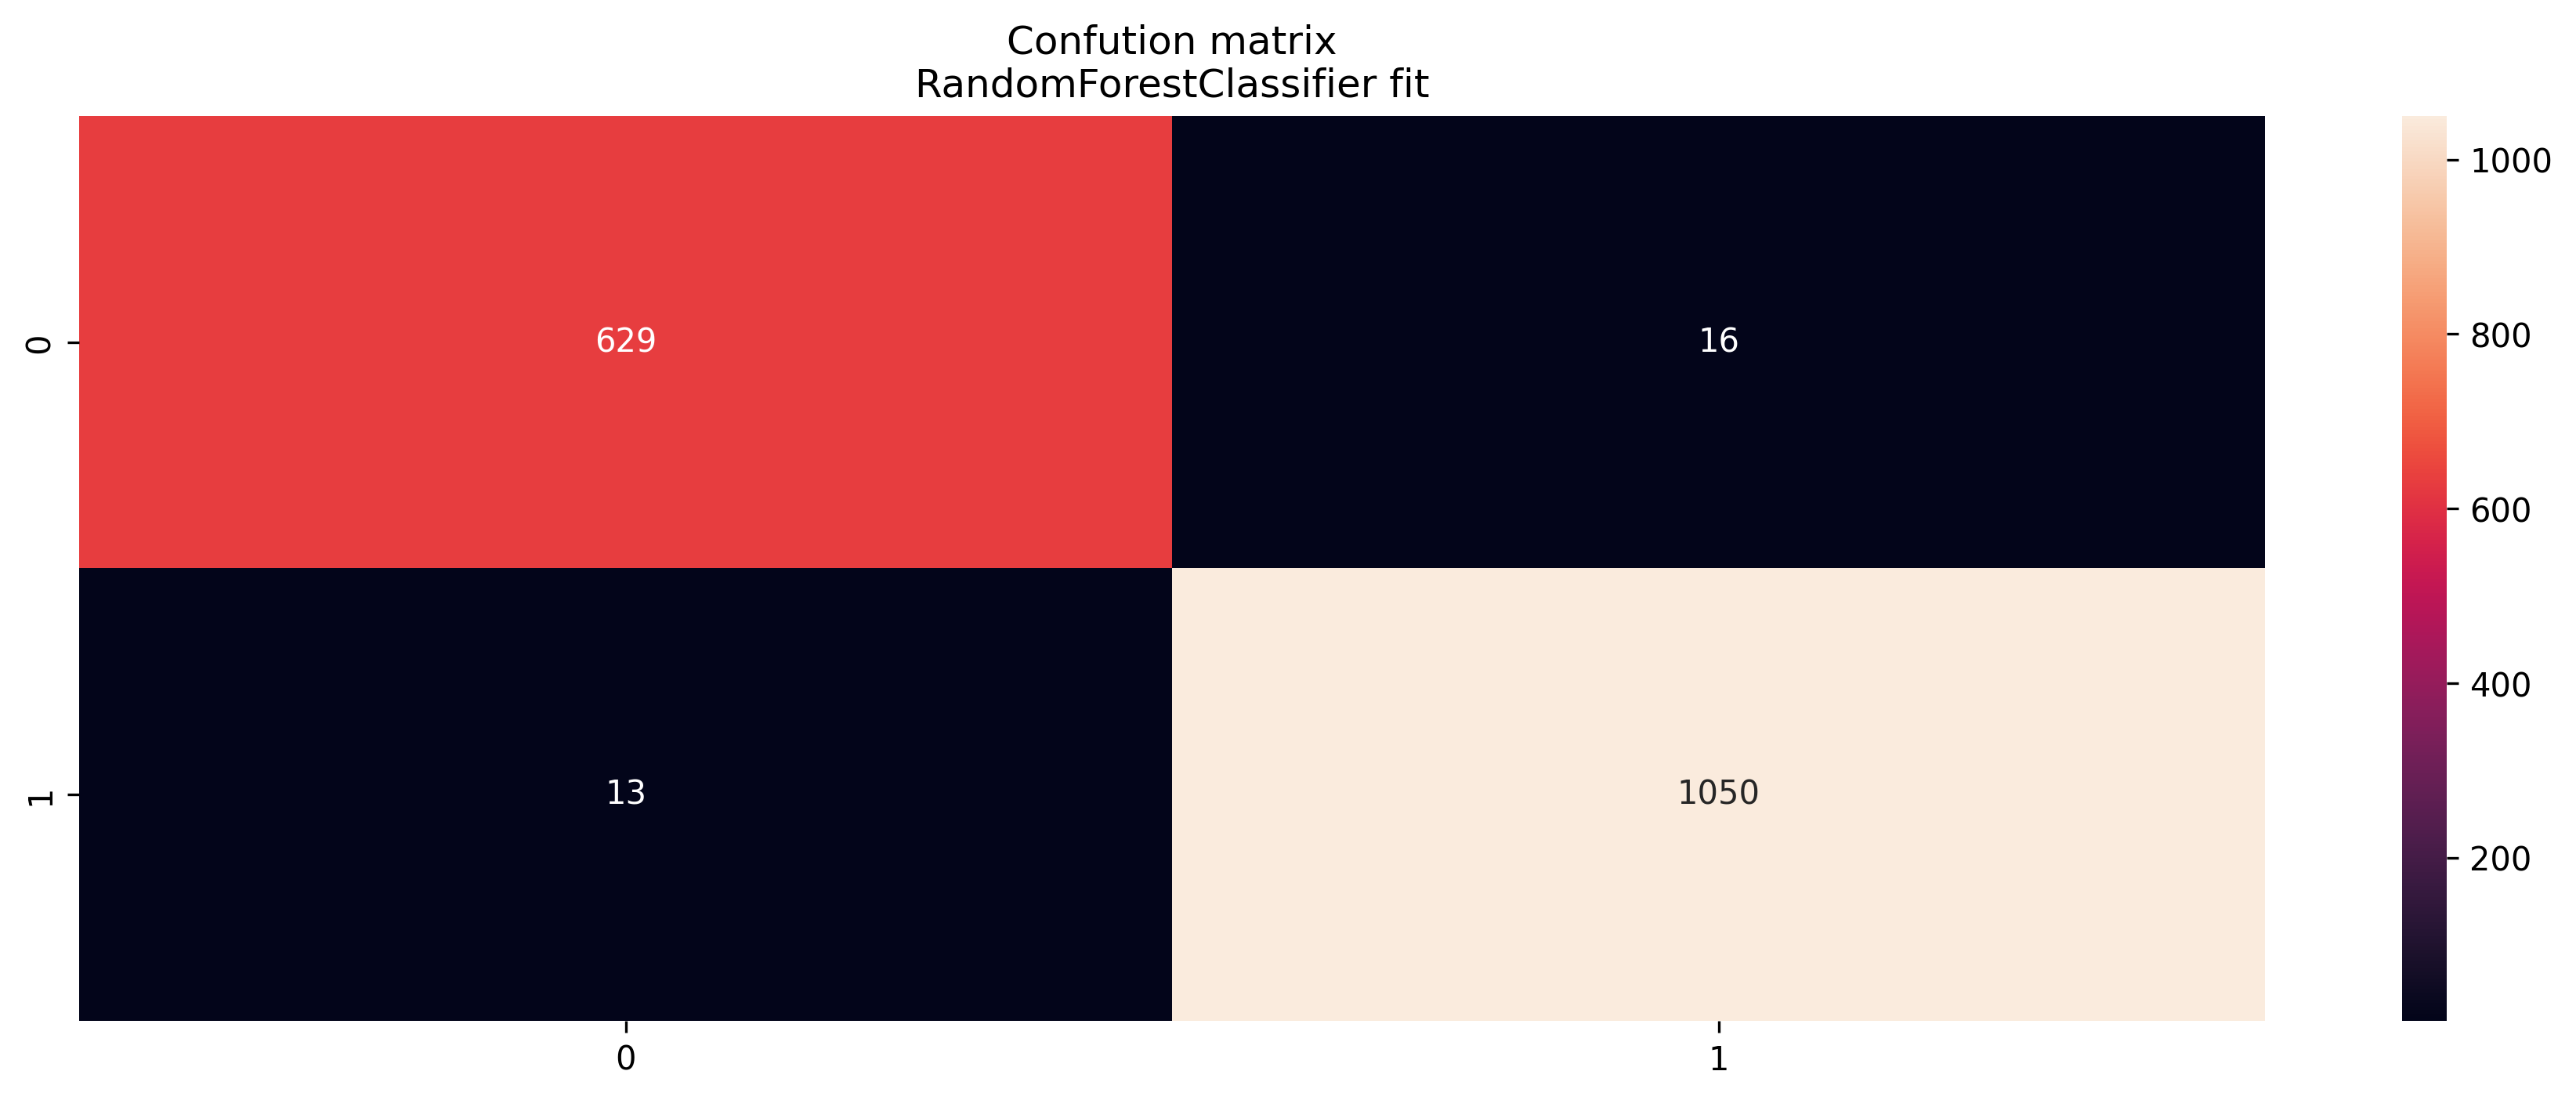

In [67]:
fig = plt.figure(figsize=(15, 5), dpi=300)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.title('Confution matrix\nRandomForestClassifier fit')
plt.show()

### Model interpretation
After evaluating the model, we check what variables were considered "important features" in the prediction.

In [68]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'score': rf.feature_importances_})
print("Feature Importances:")
feature_importances.sort_values('score', ascending=False)

Feature Importances:


,feature,score
6,cibil_score,0.83
5,loan_term,0.04
4,loan_amount,0.03
7,residential_assets_value,0.02
9,luxury_assets_value,0.02
3,income_annum,0.02
8,commercial_assets_value,0.02
10,bank_asset_value,0.02
0,no_of_dependents,0.01
2,self_employed,0.00


We can see that the most influencial feature in the prediction was `cibil_score` (83%), and that's in line with what we discovered in the exploratory analysis. Loan approval is highly influenced by the applicant's financial score.

### Loan approval probability score

Finally, the following table represents a comparison between the actual loan status (*y_true*) and the **predicted probabilities of loan approval** (*y_pred*) for various loan requests.

In [69]:
test_df = X_test.copy()
test_df['loan_status (y_true)'] = y_test
test_df['approval_proba (y_pred)'] = y_pred_proba[:, 1]
test_df[['loan_status (y_true)', 'approval_proba (y_pred)']]

,loan_status (y_true),approval_proba (y_pred)
12,0,0.00
3806,0,0.03
883,1,0.98
392,1,0.98
2894,1,1.00
...,...,...
1115,1,1.00
210,1,0.96
4172,1,0.97
3824,1,0.99
